# Dataton BC 2018

*Dirección de Capacidades Analíticas y Gobierno de Información, Grupo Bancolombia*<br>
Esta versión: *2018-10-17*<br>
Documentación tablas

## Naturaleza de los datos

Los datos entregados en este reto corresponden a transacciones realizadas por clientes persona del banco vía [PSE](https://www.pse.com.co/inicio). Estas transacciones, a diferencia de las transacciones realizadas vía POS, no cuentan con un código [MCC](https://en.wikipedia.org/wiki/Merchant_category_code) atado a la transacción, que permite conocer la categoría de comercio a la que pertence el establecimiento de comercio donde se realiza la transacción. Adicionalmente, muchas de estas transferencias por PSE corresponden a transferencias de pagos de servicios públicos, seguros, colegios, arrendamientos, y otros gastos que pueden ser denominados como gastos grandes. En el marco de un sistema de gestión de finanzas personales, poder categorizar adecuadamente estas transacciones que se realizan por PSE es de suma importancia para contar con una foto completa de la actividad de gastos de los clientes. Para este reto, los equipos participantes tendrán acceso a una muestra de transacciones PSE que corresponden a algo más de 300 mil clientes (persona), seleccionados de manera aleatoria. La tabla de transacciones cuenta con 11.8 millones de registros (uno para cada transacción), realizados entre septiembre de 2016 y octubre de 2018.

**NOTA** Los datos han pasado por un proceso relativamente simple de curación, pero se han dejado algunos ruidos en la calidad de éstos con el fin de que los equipos también lleven a cabo un proceso de inspección y limpieza.


## NOTA IMPORTANTE

Recuerden que esta información aún contiene un elevado nivel de ruido. No solo no ha sido depurada de posibles datos atípicos (transacciones de valor muy elevado) fruto de errores o transacciones fallidas, sino que también cuenta con el ruido asociado al campo de referencia, donde se involucra el factor humano, ya que son campos de texto libre que pueden contener cualquier tipo de información.

Por seguridad, hemos eliminado cualquier número presente en dichos campos de referencia (cédulas, nits, montos, contratos, etc.).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import matplotlib.animation as animation
import csv
matplotlib.style.use('seaborn')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
# from wordcloud import WordCloud

from mpl_toolkits.mplot3d import Axes3D

Cargar los datos proeprocesados de las bases de datos

In [2]:
clientes_normaliz=pd.read_csv("clientes_normaliz.csv",index_col=0)
clientes_normaliz=clientes_normaliz.astype("float64")# clientes_normaliz.round(5)
clientes_normaliz=clientes_normaliz.replace(np.nan,0)
clientes_normaliz.head()

,seg_str_EMPRENDEDOR,seg_str_OTRO,seg_str_PERSONAL,seg_str_PERSONAL PLUS,seg_str_PREFERENCIAL,ocupacion_1,ocupacion_2,ocupacion_3,ocupacion_4,ocupacion_5,...,semana_year_sum_45.0,semana_year_sum_46.0,semana_year_sum_47.0,semana_year_sum_48.0,semana_year_sum_49.0,semana_year_sum_50.0,semana_year_sum_51.0,semana_year_sum_52.0,semana_year_sum_53.0,edad
id_cliente,,,,,,,,,,,,,,,,,,,,,
18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,9.730260e-01,1.000000e-07,1.000000e-07,1.000000e-07,8.893509e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.999450
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.996997
41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,8.896102e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.073192e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.999230
47,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e-07,8.329252e-01,9.483258e-01,1.000000e-07,8.030368e-01,1.000000e-07,9.445174e-01,8.005076e-01,1.000000e-07,0.998611
71,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000e-07,1.000000e-07,9.239337e-01,8.131081e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.995996


In [12]:
dat_var=clientes_normaliz.describe().T
dat_var.head()

,count,mean,std,min,25%,50%,75%,max
seg_str_EMPRENDEDOR,330176.0,0.105662,0.307405,0.0,0.0,0.0,0.0,1.0
seg_str_OTRO,330176.0,0.001260,0.035473,0.0,0.0,0.0,0.0,1.0
seg_str_PERSONAL,330176.0,0.700172,0.458183,0.0,0.0,1.0,1.0,1.0
seg_str_PERSONAL PLUS,330176.0,0.136960,0.343806,0.0,0.0,0.0,0.0,1.0
seg_str_PREFERENCIAL,330176.0,0.055946,0.229818,0.0,0.0,0.0,0.0,1.0


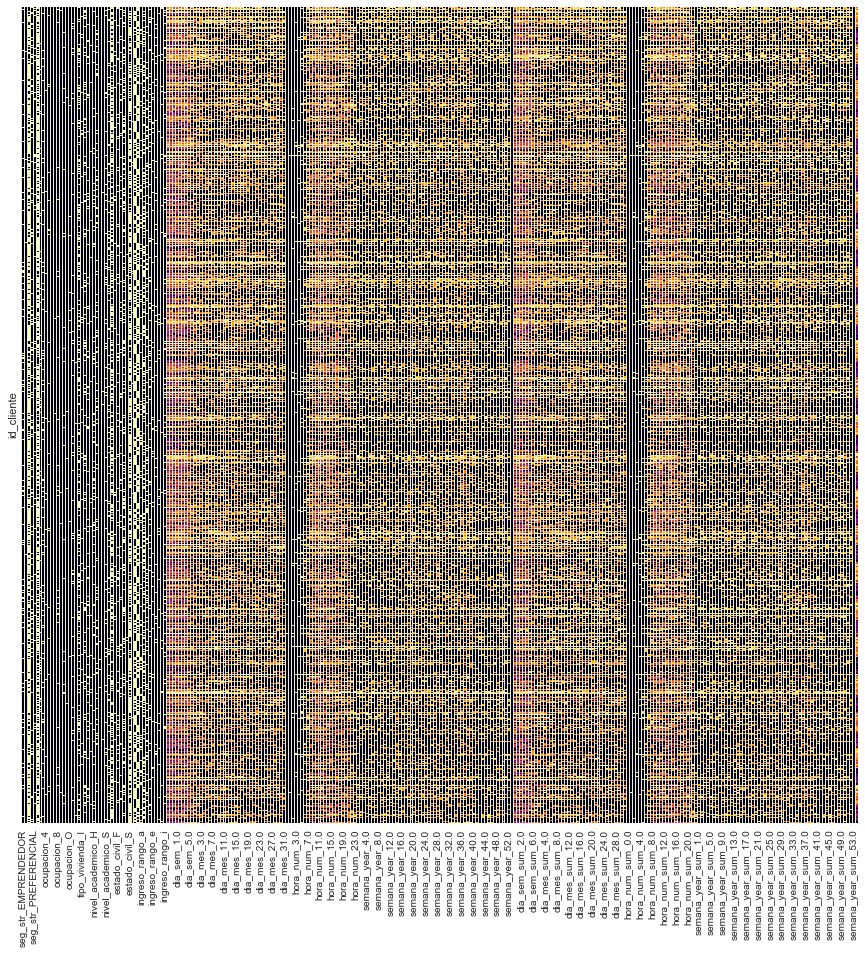

In [3]:
plt.figure(figsize=(15,15))
sns.heatmap(clientes_normaliz,yticklabels=False,cbar=False,cmap='inferno')

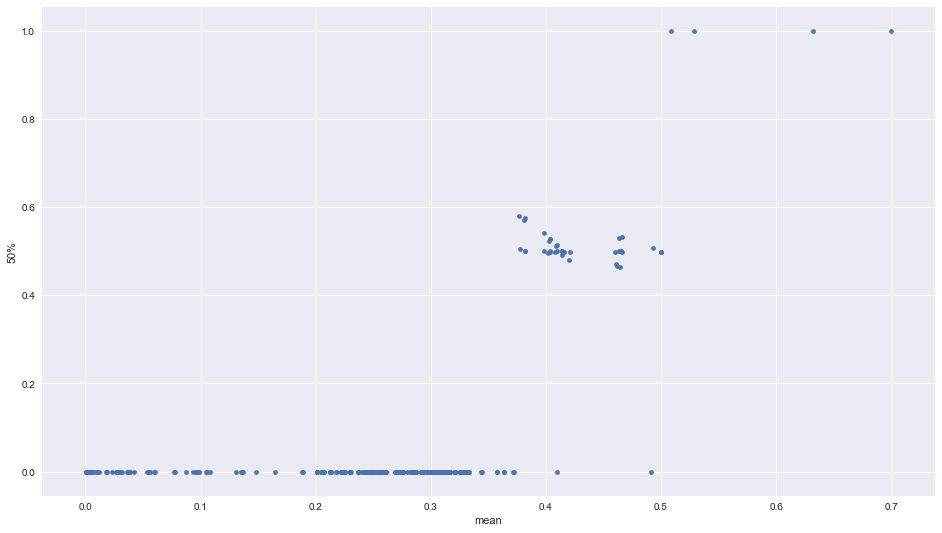

In [20]:
dat_var.plot("mean","50%",kind="scatter",figsize=(16,9))

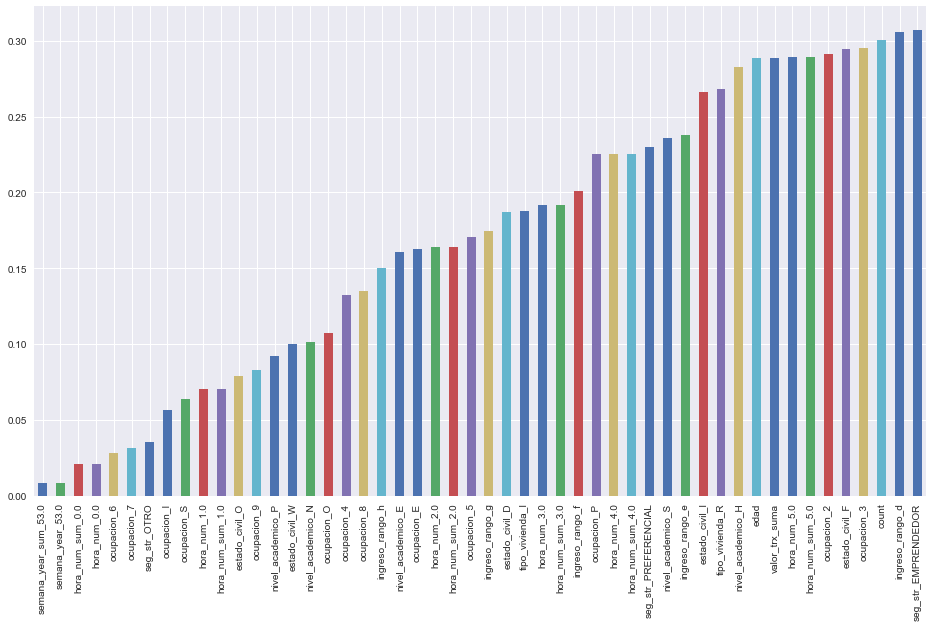

In [33]:
plt.figure(figsize=(16,9))
dat_var["std"].sort_values()[:50].plot(kind="bar")